# Few-shot Learning기반 얼굴 유사도 평가해보기

1. ORL face 데이터셋 살펴보기
2. Few-shot learning을 위한 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기
3. Siamese network 아키텍처 소개와 구현해보기
4. Contrastive loss function 설명 및 구현해보기
5. Face recognition을 위한 학습코드 작성해보기
6. 학습한 모델로 유사도 평가해보기

In [82]:
import os
from pathlib import Path

In [83]:
data_dir = "/jf-training-home/datasets_rw/Face-Recognition/"
phase = "train"

In [7]:
person_items = []

In [8]:
for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    if len(files) > 0:
        for file_name in files:
            person_items.append(os.path.join(root, file_name))

In [10]:
person_items[4]

'/jf-training-home/datasets_rw/Face-Recognition/train/s3/6.png'

In [11]:
len(person_items)

70

In [12]:
index = 0
faceA_path = person_items[index]

In [13]:
faceA_path

'/jf-training-home/datasets_rw/Face-Recognition/train/s3/1.png'

In [14]:
Path(faceA_path).parent

PosixPath('/jf-training-home/datasets_rw/Face-Recognition/train/s3')

In [17]:
#부모 directory 추출
Path(faceA_path).parent.name

's3'

In [18]:
person = Path(faceA_path).parent.name

In [19]:
person

's3'

In [20]:
same_person_dir = Path(faceA_path).parent

In [22]:
[fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

['1.png',
 '3.png',
 '9.png',
 '10.png',
 '6.png',
 '4.png',
 '8.png',
 '5.png',
 '7.png',
 '2.png']

In [24]:
same_person_images = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

In [25]:
same_person_images

['1.png',
 '3.png',
 '9.png',
 '10.png',
 '6.png',
 '4.png',
 '8.png',
 '5.png',
 '7.png',
 '2.png']

In [26]:
import numpy as np

In [27]:
np.random.choice(same_person_images)

'2.png'

In [28]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_images))

In [29]:
faceB_path

'/jf-training-home/datasets_rw/Face-Recognition/train/s3/5.png'

In [30]:
import cv2
import matplotlib.pyplot as plt

In [32]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

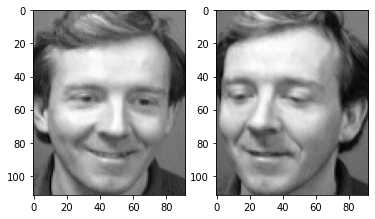

In [33]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

In [34]:
person

's3'

In [40]:
while True:
    faceB_path = np.random.choice(person_items)
    if person != Path(faceB_path).parent.name:
        break

In [36]:
faceB_path

'/jf-training-home/datasets_rw/Face-Recognition/train/s8/6.png'

In [38]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

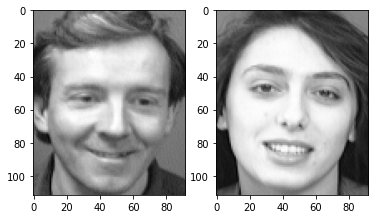

In [39]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

# Few-shot learning을 위한 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [41]:
class Face_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.person_items)

    def __getitem__(self, index):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name

        same_person = np.random.randint(2)
        
        if same_person:
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))
        else:
            while True:
                faceB_path = np.random.choice(self.person_items)
                if person != Path(faceB_path).parent.name:
                    break
        
        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)

        if self.transformer:
            faceA_image = self.transformer(faceA_image)
            faceB_image = self.transformer(faceB_image)

        return faceA_image, faceB_image, np.array([1-same_person])

# 동일인물일때 (positive sampling) -> label/target : 0
# 다른인물일때 (negative sampling) -> label/target : 1

In [42]:
data_dir = "/jf-training-home/datasets_rw/Face-Recognition/"
trn_ds = Face_Dataset(data_dir, phase="train")

In [43]:
index = 0
faceA, faceB, other = trn_ds[index]

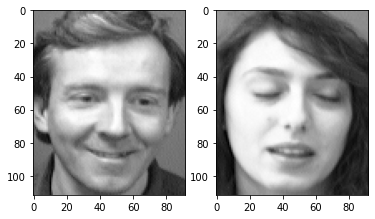

[1]


In [44]:
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
plt.show()
print(other)

In [45]:
from ipywidgets import interact

In [46]:
@interact(index=(0, len(trn_ds)-1))
def show_sample(index=0):
    faceA, faceB, other = trn_ds[index]
    plt.figure(figsize=(6, 6))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    plt.show()
    print(other)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [47]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [53]:
def build_transformer(image_size=100):
    transformers = {}
    transformers["train"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
    
    transformers["val"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
    return transformers

In [54]:
IMAGE_SIZE = 100
transformers = build_transformer(image_size=IMAGE_SIZE)

In [55]:
train_dataset = Face_Dataset(data_dir=data_dir, phase="train", transformer=transformers["train"])
val_dataset = Face_Dataset(data_dir=data_dir, phase="val", transformer=transformers["val"])

In [56]:
train_dataset[0]

(tensor([[[-0.1294, -0.1608, -0.1529,  ..., -1.0000, -1.0000, -1.0000],
          [-0.1529, -0.1451, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
          [-0.1373, -0.1294, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.6784, -0.6627, -0.7176,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6627, -0.6863, -0.6941,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6784, -0.6706, -0.6627,  ..., -1.0000, -1.0000, -1.0000]]]),
 tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.5059, -0.4431,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.8824, -0.8667,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]]),
 array([0]))

In [57]:
val_dataset[0][0].shape

torch.Size([1, 100, 100])

In [59]:
tr_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=64)

In [60]:
def build_dataloader(data_dir, batch_size=64):
    dataloaders = {}
    
    transformers = build_transformer()
    train_dataset = Face_Dataset(data_dir=data_dir, phase="train", transformer=transformers["train"])
    val_dataset = Face_Dataset(data_dir=data_dir, phase="val", transformer=transformers["val"])
    
    dataloaders["train"] = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    dataloaders["val"] = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
    return dataloaders

In [62]:
data_dir = "/jf-training-home/datasets_rw/Face-Recognition/"
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)

In [63]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f7b26f45880>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f7b26f947f0>}

In [64]:
for _ in range(3):
    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            faceAs = batch[0]
            faceBs = batch[1]
            others = batch[2]
            
            if index % 100 == 0:
                print(f"{phase} - {index}/{len(dataloaders[phase])}")

train - 0/2
val - 0/1
train - 0/2
val - 0/1
train - 0/2
val - 0/1


# 3. Siamese Network 아키텍처 소개와 구현해보기

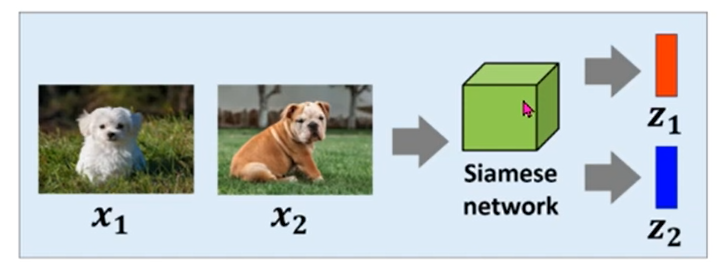

In [65]:
import torch
from torch import nn

In [74]:
def ConvBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
    )

In [75]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        
        self.features = nn.Sequential(
            ConvBlock(input_channel, 4),
            ConvBlock(4, 8),
            ConvBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )
    
    def forward(self, x1, x2):
        z1 = self.features(x1)
        z2 = self.features(x2)
        return z1, z2

In [76]:
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)

model = SiameseNetwork(input_channel=1)

z1, z2 = model(x1, x2)

In [79]:
print(z1.shape, z2.shape)

torch.Size([1, 10]) torch.Size([1, 10])


In [80]:
z1

tensor([[-0.0757,  0.0864,  0.0175, -0.0433, -0.1060, -0.0260, -0.1715, -0.1463,
         -0.0098, -0.0297]], grad_fn=<AddmmBackward0>)

In [81]:
z2

tensor([[-0.0117,  0.0989, -0.0519, -0.0631,  0.0390,  0.0569, -0.1865, -0.1540,
         -0.1481, -0.0849]], grad_fn=<AddmmBackward0>)

# 4. Contrastive loss function 설명 및 구현해보기
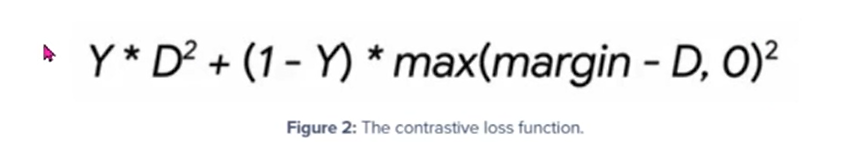

- D^2(거리 제곱)의 거리를 줄이는 방향으로 학습
- 가까운 것은 더 가까이 먼 것은 더 멀리



출처 : https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/

In [86]:
"""
Label
same perspon -> 0 
other person -> 1
"""

'\nLabel\nsame perspon -> 0 \nother person -> 1\n'

In [84]:
import torch.nn.functional as F

In [163]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        
    def forward(self, z1, z2, label):
        dist = F.pairwise_distance(z1, z2, keepdim=True) # 두 vector 간의 distance를 계산 해줌
        loss = torch.mean((1-label) * torch.pow(dist,2) + label * torch.pow(torch.clamp((self.margin - dist), min=0), 2))
        acc = ((dist > 0.6) == label).float().mean()
        return loss, acc
        

In [121]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.clamp(self.margin**2 - torch.pow(euclidean_distance, 2), min=0.0))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

# Face Recognition을 위한 학습코드 작성해보기

In [164]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_acc = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            imgA = batch[0].to(device)
            imgB = batch[1].to(device)
            label = batch[2].to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                codeA, codeB = model(imgA, imgB)
            loss, acc = criterion(codeA, codeB, label)
                
            if phase == "train":
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            running_acc += acc.item()
                    
        losses[phase] = running_loss/len(dataloaders[phase])
        accuracies[phase] = running_acc/len(dataloaders[phase])
    return losses, accuracies

In [165]:
def save_model(model_state, model_name):
    save_dir = "./trained_model"
    os.makedirs("./trained_model", exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [183]:
data_dir = "/jf-training-home/datasets_rw/Face-Recognition/"
is_cuda = True

IMAGE_SIZE = 100
BATCH_SIZE = 256
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = SiameseNetwork(input_channel=1)
model = model.to(DEVICE)
criterion = ContrastiveLoss(margin=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [184]:
num_epochs = 100

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accs = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss.append(losses["train"])
    train_acc.append(accs["train"])
    val_loss.append(losses["val"])
    val_acc.append(accs["val"])
    
    print(f"{epoch}/{num_epochs} - train loss:{losses['train']:.4f}, val loss:{losses['val']:.4f}, train acc:{accs['train']:.4f}, val acc:{accs['val']:.4f}")
    
    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f"model_{epoch+1}.pth")

0/100 - train loss:1.5430, val loss:2.1200, train acc:0.4857, val acc:0.4667
1/100 - train loss:1.0970, val loss:1.5798, train acc:0.6286, val acc:0.6000
2/100 - train loss:1.3287, val loss:1.6969, train acc:0.5000, val acc:0.5667
3/100 - train loss:1.1756, val loss:1.4244, train acc:0.7000, val acc:0.6333
4/100 - train loss:0.7388, val loss:2.0472, train acc:0.5857, val acc:0.4667
5/100 - train loss:0.6176, val loss:1.8699, train acc:0.7143, val acc:0.5000
6/100 - train loss:0.6348, val loss:1.6952, train acc:0.6000, val acc:0.5333
7/100 - train loss:0.9887, val loss:1.4416, train acc:0.5571, val acc:0.6000
8/100 - train loss:0.7923, val loss:1.3739, train acc:0.5857, val acc:0.6000
9/100 - train loss:0.6766, val loss:2.0823, train acc:0.6143, val acc:0.3667
10/100 - train loss:0.7674, val loss:1.7707, train acc:0.5571, val acc:0.4333
11/100 - train loss:0.5206, val loss:1.3097, train acc:0.6571, val acc:0.5667
12/100 - train loss:0.3721, val loss:1.2089, train acc:0.6429, val acc:0.5

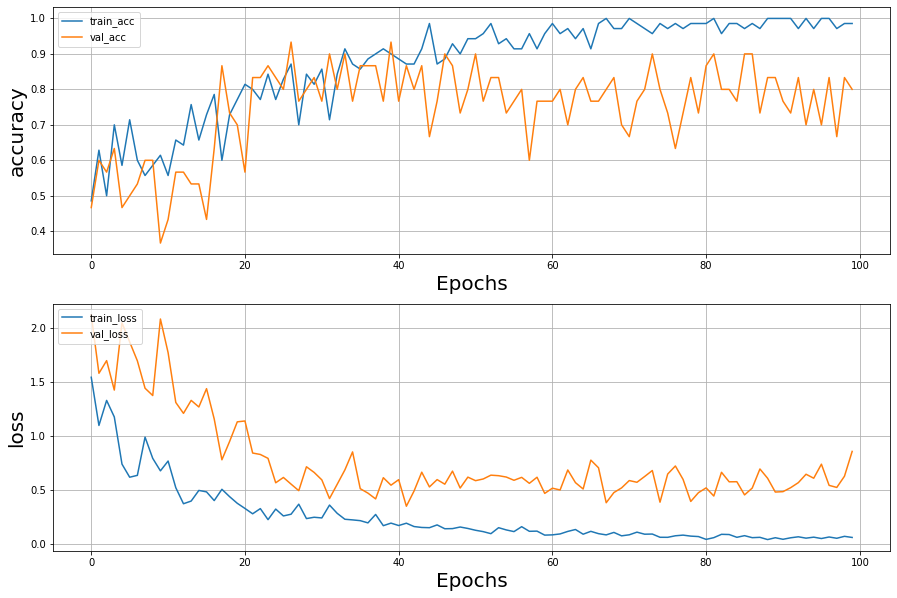

In [185]:
plt.figure(figsize=(15,10))
plt.subplot(212)
plt.plot(range(num_epochs), train_loss, label = "train_loss")
plt.plot(range(num_epochs), val_loss, label = "val_loss")
plt.legend(loc = 'upper left')
plt.xlabel("Epochs", size=20)
plt.ylabel("loss", size=20)
plt.grid(True)

plt.subplot(211)
plt.plot(range(num_epochs), train_acc, label = "train_acc")
plt.plot(range(num_epochs), val_acc, label = "val_acc")
plt.legend(loc = 'upper left')
plt.xlabel("Epochs", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(True)

# 유클리디언
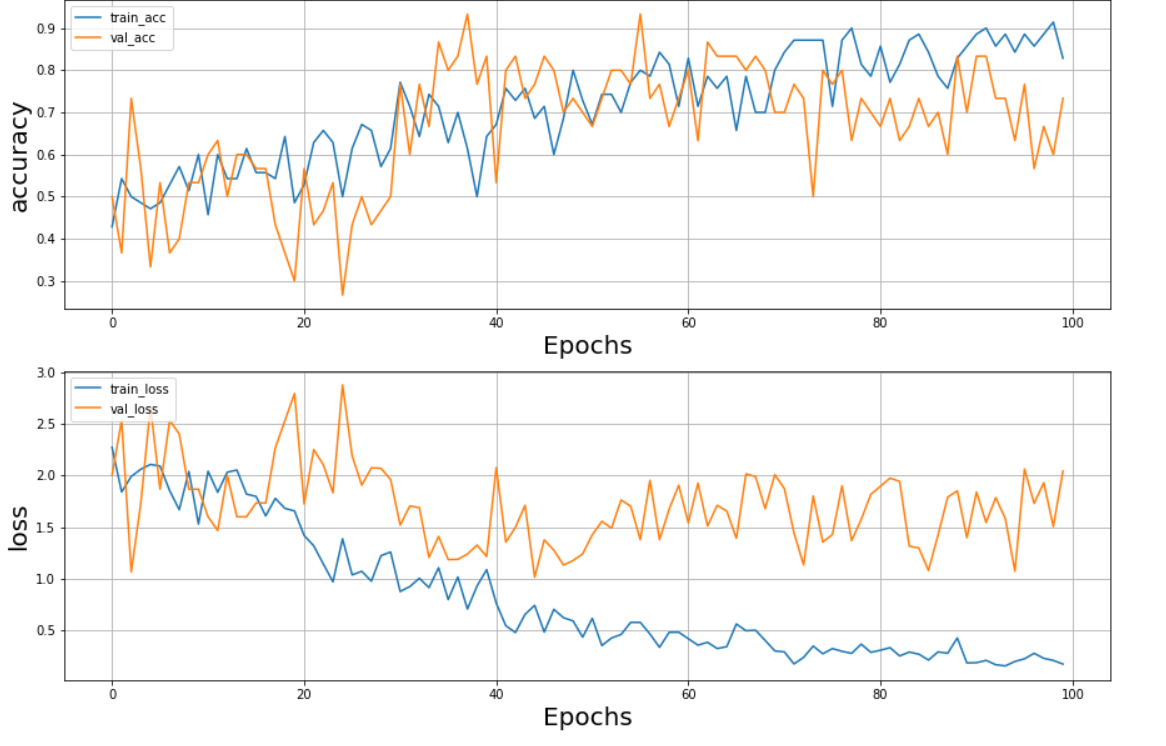

# 기본
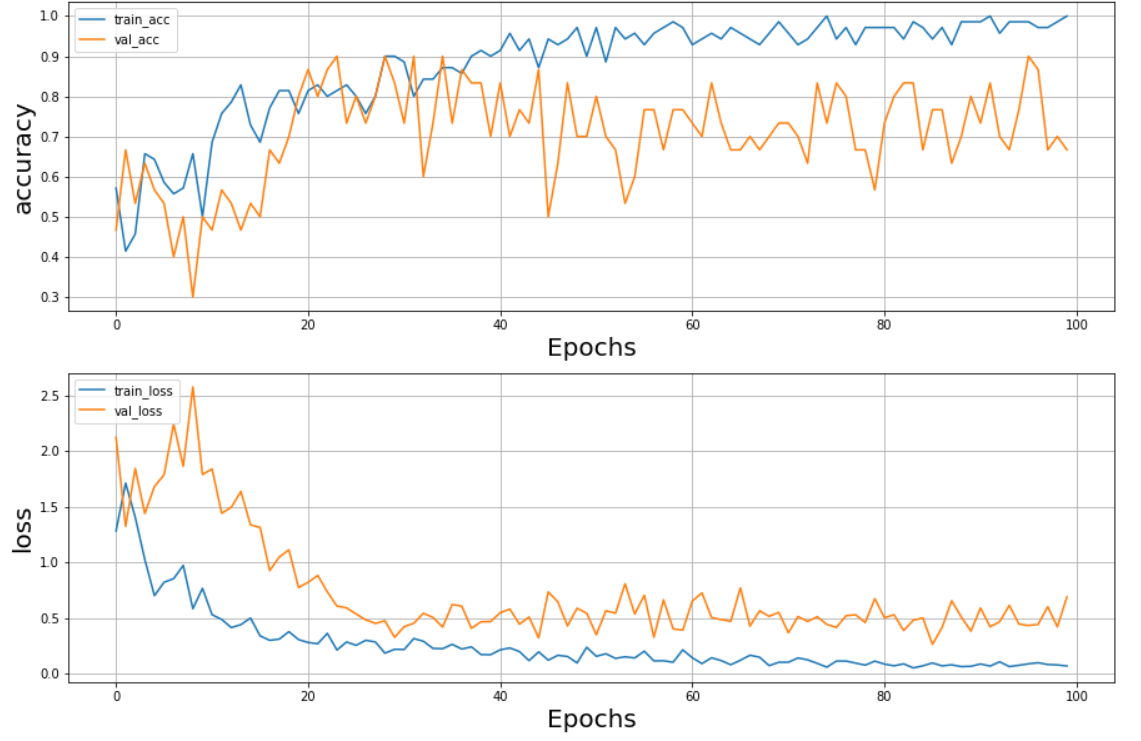

# 학습한 모델로 유사도 평가해보기

In [192]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork(input_channel=1)
    model.load_state_dict(checkpoint)
    print(model.load_state_dict(checkpoint))
    model.eval()
    return model.to(device)

In [193]:
ckpt_path = "./trained_model/model_100.pth"
is_cuda = False

IAMGE_SIZE = 100
DEVICE = torch.device('cpu')
model = load_model(ckpt_path, DEVICE)

<All keys matched successfully>


In [194]:
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

In [197]:
@torch.no_grad()
def recognize_face(dataset, index, model, device):
    val_dataset = dataset(data_dir, phase="val")
    faceA, faceB, label = val_dataset[index]
    tensor_faceA = transformer(faceA).to(device) # (C, H, W) / (1, 100, 100)
    tensor_faceB = transformer(faceB).to(device) # (C, H, W) / (1, 100, 100)
    
    codeA, codeB = model(tensor_faceA.unsqueeze(0), tensor_faceB.unsqueeze(0)) # (B, C, H, W) / (1, 1, 100, 100)
    dist = F.pairwise_distance(codeA, codeB)
    
    output = "same person" if dist.item() < 0.6 else "different person"
    return faceA, faceB, dist.item(), output

In [198]:
@interact(index=(0,29))
def show_result(index=0):
    faceA, faceB, dist, output = recognize_face(Face_Dataset, index, model, DEVICE)
    
    plt.figure(figsize=(7,4))
    plt.suptitle(f"{output} - dissimilarity:{dist:.2f}")
    plt.subplot(121)
    plt.imshow(faceA, cmap = "gray")
    plt.subplot(122)
    plt.imshow(faceB, cmap = "gray")

interactive(children=(IntSlider(value=0, description='index', max=29), Output()), _dom_classes=('widget-intera…